# Predicting the Next Wave Signal using LSTM

Suryasatriya Trihandaru

Data Science, FSM UKSW

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib notebook

## Data Preparation

We create a data that simulate a wave propagation. There are M points of data for each time step. There are N rows that are not independent one another. The animation below will show the situation.

In [2]:
N = 100 # number of frames of signal measurement.
M = 100 # length of wave signal.
x = np.linspace(0,1,M)
y = np.sin(20*x)*np.cos(50*x)

In [3]:
X=[]
for i in range(N):
    y = np.sin(20*x-i)*np.cos(50*x-2*i)
    X.append(y)
X=np.array(X)

<IPython.core.display.Javascript object>


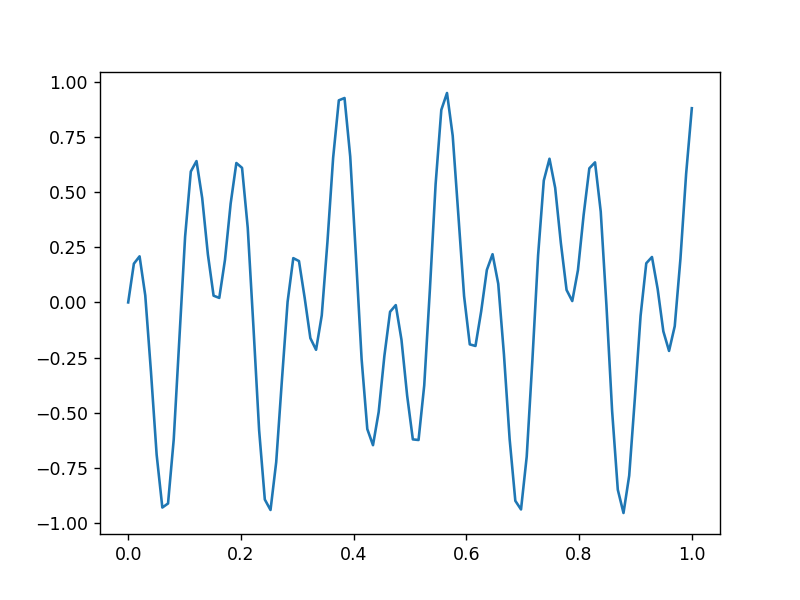

In [4]:
plt.plot(x,X[0,:])
plt.show()

## Animation

<IPython.core.display.Javascript object>


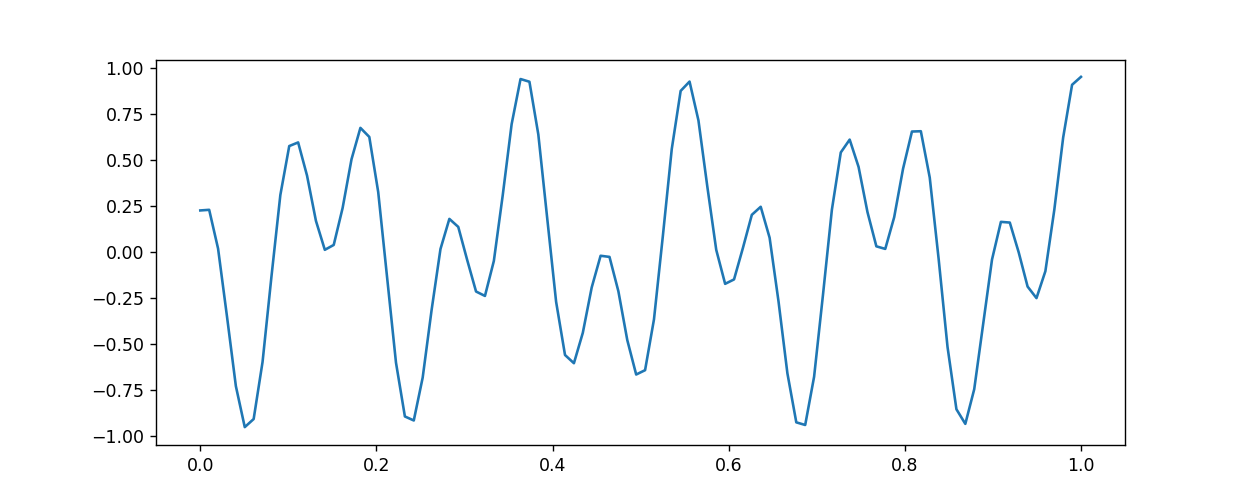

In [5]:
fig, ax = plt.subplots(figsize=(10,4))
line, = ax.plot(x, X[0,:])
def animate(i):
    line.set_ydata(X[i,:])  # update the data
    return line,
# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = FuncAnimation(fig, animate, np.arange(1, N-1), init_func=init,
                              interval=100, blit=True)
plt.show()

## Data Construction for LSTM

In [6]:
K = 10  # number of time steps in each sequence
stride = 1  # stride between adjacent sequences

# Convert X into sequences
X_seq = []
y_seq = []
for i in range(0, N - K, stride):
    seq = X[i:i+K]
    target = X[i+K]
    X_seq.append(seq)
    y_seq.append(target)

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [7]:
X_seq.shape

(90, 10, 100)

In [8]:
y_seq.shape

(90, 100)

In [9]:
# Reshape input sequence into 2D tensor
X_seq = np.reshape(X_seq, (X_seq.shape[0], K*M))
X_seq.shape

(90, 1000)

## Neural Network Model

In [10]:
num_hidden_layers = 5  # number of hidden LSTM layers
hidden_layer_size = 256  # number of units in each hidden LSTM layer
batch_size = 1  # number of sequences in each batch

# Define the model
model = Sequential()
model.add(LSTM(units=hidden_layer_size, batch_input_shape=(batch_size, K*M, 1), stateful=True, return_sequences=True))
for i in range(num_hidden_layers - 2):
    model.add(LSTM(units=hidden_layer_size, stateful=True, return_sequences=True))
model.add(LSTM(units=hidden_layer_size, stateful=True))
model.add(Dense(units=M, activation='linear'))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1000, 256)            264192    
                                                                 
 lstm_1 (LSTM)               (1, 1000, 256)            525312    
                                                                 
 lstm_2 (LSTM)               (1, 1000, 256)            525312    
                                                                 
 lstm_3 (LSTM)               (1, 1000, 256)            525312    
                                                                 
 lstm_4 (LSTM)               (1, 256)                  525312    
                                                                 
 dense (Dense)               (1, 100)                  25700     
                                                                 
Total params: 2,391,140
Trainable params: 2,391,140
Non-

It's important to note that when using a stateful LSTM, we need to be careful about the order in which the input sequences are fed to the model during training and prediction. In the example above, we're using a stride of 1 between adjacent sequences, which ensures that the order of the input sequences is preserved. However, if you change the stride or use a different method to generate the input sequences, you may need to adjust the order in which the sequences are fed to the model to ensure that the state is correctly propagated between sequences.

Also, note that when using a stateful LSTM, we need to make sure that the batch size is set to 1 during prediction, since each sequence is dependent on the previous sequence and we need to ensure that the state of the LSTM is correctly propagated between predictions.

During training, we need to manually loop over the input sequences and call fit on each batch of sequences, making sure to reset the state of the LSTM between batches using the reset_states method.

In [11]:
# Train the model
num_batches = X_seq.shape[0] // batch_size
for i in range(num_batches):
    X_batch = X_seq[i*batch_size:(i+1)*batch_size]
    y_batch = y_seq[i*batch_size:(i+1)*batch_size]
    model.fit(X_batch, y_batch, epochs=1, batch_size=batch_size, shuffle=False)
    model.reset_states()

1/1 [==============================] - 4s 4s/step - loss: 0.1231


## Predict the next Row

In [12]:
# Make predictions
X_test = X[:-1]
last_K_rows = X_test[-K:]  # Get the last K rows of the test data
last_K_rows = np.reshape(last_K_rows, (1, K*M, 1))  # Reshape into a 3D tensor
y_pred = model.predict(last_K_rows, batch_size=1)  # Predict the next sample


1/1 [==============================] - 3s 3s/step


In [13]:
y_pred.shape

(1, 100)

In [14]:
X_test[-1,:].shape

(100,)

<IPython.core.display.Javascript object>


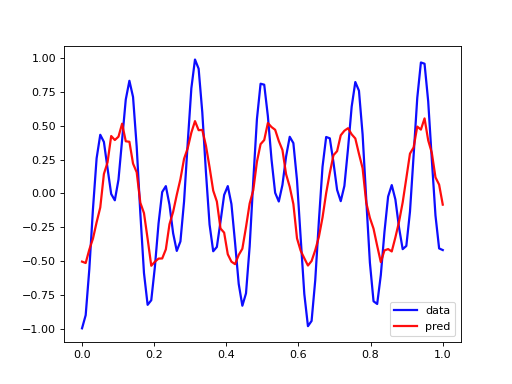

In [15]:
plt.plot(x, X[-1,:],c='b', linewidth=2, alpha=0.95, label='data')
plt.plot(x,y_pred.ravel(), c='r', linewidth=2, alpha=0.95, label='pred')
plt.legend()
plt.show()